# 1. Install and Import Baseline Dependencies

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install chromedriver-binary
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chromedriver-binary: filename=chromedriver_binary-114.0.5735.90.0-py3-none-any.whl size=7356398 sha256=56a906fb4b533b576e3f8712488efb4f696c6c92e532bca2a585ad4a8d6fc51b
  Stored in directory: /root/.cache/pip/wheels/53/87/f9/ee0032c0926754afc88e4e146383a477f90cb88a3fae04bfdd
Successfully built chromedriver-binary
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s

In [ ]:
%%shell

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

apt-get update
apt-get install chromium
apt-get install chromium chromium-driver

Executing: /tmp/apt-key-gpghome.7hAQTrqWtK/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.VEsc52Tds1/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.vjvmg6PWnJ/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 https://cloud.r-project.org/bin/l

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import re
from transformers import pipeline
import csv
import datetime
import time
import pandas as pd
import numpy as np

#2. Setup Summarization Model

In [ ]:
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# 3. Building a News and Sentiment Pipeline

In [ ]:
monitored_tickers = ['TSLA', 'ETH']
start_date = datetime.date(2023, 3, 3)
end_date = datetime.date(2023, 4, 3)
delta = datetime.timedelta(days=1)

days = []
while (start_date <= end_date):
  days.append(start_date)
  start_date += delta

## 3.1 Search for Stock News using Google and Finanzen.net & Strip unwanted URLS

In [ ]:
def web_driver():
    options = webdriver.ChromeOptions()
    # make sure the --verbose option is the first argument
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    # the chrome in linux only supports headless browser
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--disable-dev-shm-usage')

    return webdriver.Chrome(options=options)

def search_link(ticker, day):
    url = "https://www.google.com/search?q=finanzen.net+{}".format(ticker)+"&tbs=cdr%3A1%2Ccd_min%3A+{}".format(str(day.strftime('%m')))+"%2F{}".format(str((day).strftime('%d')))+"%2F{}".format(str((day).strftime('%Y')))+"%2Ccd_max%3A{}".format(str((day).strftime('%m')))+"%2F{}".format(str((day).strftime('%d')))+"%2F{}".format(str((day).strftime('%Y')))+"&tbm"
    driver = web_driver()
    driver.get(url)
    soup = BeautifulSoup(driver.page_source,'html.parser')
    items = soup.find_all('div',{'class':'yuRUbf'})

    hrefs = []
    for item in items:
      href = item.find('a')['href']
      if 'https://www.finanzen.net/' in href:
        hrefs.append(href)
    time.sleep(5)
    driver.quit()
    return hrefs

#urls = []
dic_ticker = []
dic_urls = []
#dic_urls_pre  = []

for ticker in monitored_tickers:
  urls =[]
  dic_ticker = []
  dic_ticker.append(ticker)
  for day in days:
      #urls = []
      #urls.append(search_link(ticker, day))
      #dic1.append(ticker)
      dic_ticker.append(day)
      #dic_urls_pre.append(day)
      dic_ticker.append(search_link(ticker, day))
      #dic_urls_pre.append(urls)
  dic_urls.append(dic_ticker)

#dic_urls

### 3.1.1 Preprocess and transfer data

In [ ]:
#transfer data into  pandas dataframe

df = pd.DataFrame(dic_urls)
df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]
df = df[::-1].reset_index(drop=True)
df_index = pd.DataFrame()
df_index = df.loc[1::2]
df_index['DATE'] = df_index[dic_urls[0][0]]
df_index = df_index[::-1].reset_index(drop=True)
df = df.drop(df.index[1::2])
df = df[::-1].reset_index(drop=True)
df = df.set_index(df_index['DATE'])

#df

<ipython-input-45-2fa616f57045>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index['DATE'] = df_index[dic_urls[0][0]]


## 3.2 Search and Scrape Cleaned URLS

In [ ]:
def scrape_and_process(URLS):
    ARTICLES = []
    for url in URLS:
        time.sleep(5)
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = [paragraph.text for paragraph in paragraphs]
        words = ' '.join(text).split(' ')[:500]
        ARTICLE = ' '.join(words)
        ARTICLES.append(ARTICLE)
    return ARTICLES

for (colname,colval) in df.items():
    df[colname + '-TEXT'] = '[]'
    lst_col = []
    lst_val = []
    print()
    for value in colval.values:
      if value != '[[]]':
        lst_val.append(scrape_and_process(value))
        lst_col.append(lst_val)
        lst_val = []
      else:
        lst_val.append(value)
        lst_col.append(lst_val)
        lst_val = []
      #if value != []:
    df[colname + '-TEXT'] = lst_col

#df

In [ ]:
#df

In [ ]:
df = df.drop(['TSLA-SUMMARY-SUMMARY'], axis=1)

## 3.3 Summarize all Articles

In [ ]:
def summarize(articles):
    summaries = []
    for article in articles:
        input_ids = tokenizer.encode(article,truncation=True, padding="longest", return_tensors='pt')
        #input_ids = tokenizer.encode_plus(article, add_special_tokens=True, max_length=512, truncation=True, padding="max_length")
        output = model.generate(input_ids, max_length=85, num_beams=5, early_stopping=True)
        summary = tokenizer.decode(output[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

for (colname,colval) in df.items():
    if 'SUMMARY' not in colname and 'TEXT' not in colname:
      print(colname)
      df[colname + '-SUMMARY'] = '[]'
      lst_col = []
      lst_val = []
      for value in colval.values:
        if value != '[[]]':
          lst_val.append(summarize(value))
          lst_col.append(lst_val)
          lst_val = []
        else:
          lst_val.append(value)
          lst_col.append(lst_val)
          lst_val = []
      #if value != []:
      df[colname + '-SUMMARY'] = lst_col

#df

TSLA
ETH
TSLA-SUMMARY


ValueError: ignored

# 4. Adding Sentiment Analysis

In [ ]:
#df.to_csv('data.csv')

In [ ]:
sentiment = pipeline('sentiment-analysis')

for (colname,colval) in data.items():
    if 'SUMMARY' not in colname and 'TEXT' not in colname:
      print('')
    elif 'SUMMARY' in colname and 'SENTIMENT' not in colname:
      print(colname)
      lst_col_label = []
      lst_col_score = []
      lst_val = []
      for value in colval.values:
        if value != '[[]]':
          lst_val.append((sentiment(value)[0]))
          lst_col_label.append(lst_val[0]['label'])
          lst_col_score.append(lst_val[0]['score'])
          lst_val = []
        else:
          lst_val.append(value)
          #print(lst_col_label[-1])
          lst_col_label.append(lst_val)
          lst_col_score.append(lst_val)
          lst_val = []
      data[colname + '-SENTIMENT-LABEL'] = lst_col_label
      data[colname + '-SENTIMENT-SCORE'] = lst_col_score

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.




TSLA-SUMMARY
NEGATIVE
['[[]]']
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
['[[]]']
ETH-SUMMARY


In [ ]:
data

,TSLA,ETH,TSLA-TEXT,ETH-TEXT,TSLA-SUMMARY,ETH-SUMMARY,TSLA-SUMMARY-SENTIMENT-LABEL,TSLA-SUMMARY-SENTIMENT-SCORE,ETH-SUMMARY-SENTIMENT-LABEL,ETH-SUMMARY-SENTIMENT-SCORE
DATE,,,,,,,,,,
2023-03-03,['https://www.finanzen.net/nachricht/aktien/mo...,['https://www.finanzen.net/nachricht/devisen/e...,[['Neu auf finanzen.net? \nKostenfrei registri...,"[[""Neu auf finanzen.net? \nKostenfrei registri...","[['Model 3 rivale joint-venture in China.', 'P...",[['ethereum-news-shanghai-upgrade-erst-im-apri...,NEGATIVE,0.996452,NEGATIVE,0.996396
2023-03-04,[],['https://www.finanzen.net/nachricht/devisen/p...,[[]],[['Neu auf finanzen.net? \nKostenfrei registri...,[[]],"[['Bitstamp, Ethereum set to hold initial publ...",[[[]]],[[[]]],NEGATIVE,0.995123
2023-03-05,[],['https://www.finanzen.net/nachricht/devisen/k...,[[]],[['Neu auf finanzen.net? \nKostenfrei registri...,[[]],[['Krafftbericht der Bitcoin-Ethereum-Co-wiesi...,[[[]]],[[[]]],NEGATIVE,0.996128
2023-03-06,['https://www.finanzen.net/nachricht/aktien/te...,['https://www.finanzen.net/nachricht/devisen/n...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Tesla-ein-drahtseilakt ist gefllt in Berlin...,[['U.S.-based e-commerce giant Alibaba has lau...,NEGATIVE,0.992237,NEGATIVE,0.971084
2023-03-07,['https://www.finanzen.net/nachricht/aktien/un...,['https://www.finanzen.net/devisen/apecoin-dol...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Tesla Model 3 in USA to go on sale in autum...,[['apecoin-dollar-kurs are a new form of crypt...,NEGATIVE,0.992243,NEGATIVE,0.997180
2023-03-08,['https://www.finanzen.net/nachricht/aktien/im...,['https://www.finanzen.net/nachricht/devisen/1...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Titel-tesla-aktie-in-rot-us-verkehrsaufsich...,[['Managershaelt-bei-Bitcoin-eine-Massive-stei...,NEGATIVE,0.993282,NEGATIVE,0.997113
2023-03-09,['https://www.finanzen.net/nachricht/aktien/ke...,['https://www.finanzen.net/nachricht/devisen/k...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Titel-tesla-hat-nachunterung-aenderungen am...,[['Konkurrenz-oder-koder-themen-ki-und-metaver...,NEGATIVE,0.99626,NEGATIVE,0.996791
2023-03-10,['https://www.finanzen.net/nachricht/aktien/to...,['https://www.finanzen.net/nachricht/devisen/k...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Neu auf finanzen.net? \nKostenfrei registri...,[['Titel-tesla model-y-ueberzeugt-bei crash-te...,[['Dogecoin is an Ethereum-based virtual curre...,NEGATIVE,0.998474,NEGATIVE,0.993783
2023-03-11,[],['https://www.finanzen.net/devisen/tether-us-d...,[[]],[['Neu auf finanzen.net? \nKostenfrei registri...,[[]],[['Tether-us-dollar-kurs are now legal in Denm...,[[[]]],[[[]]],NEGATIVE,0.993200


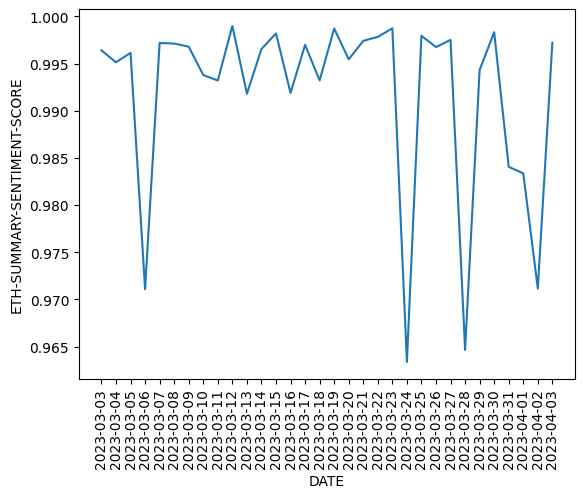

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=data, x="DATE", y="ETH-SUMMARY-SENTIMENT-SCORE")
plt.xticks(rotation=90)
plt.show()

In [ ]:
data = pd.read_csv('/content/sample_data/data (2).csv')
data = data.set_index('DATE')